In [8]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
file_path = "/Users/seanlavi/dev/Schizophrenic_Speech/data/word_features_analysis.json"
with open(file_path, 'r', encoding = 'utf-8') as f:
    data_js = json.load(f)

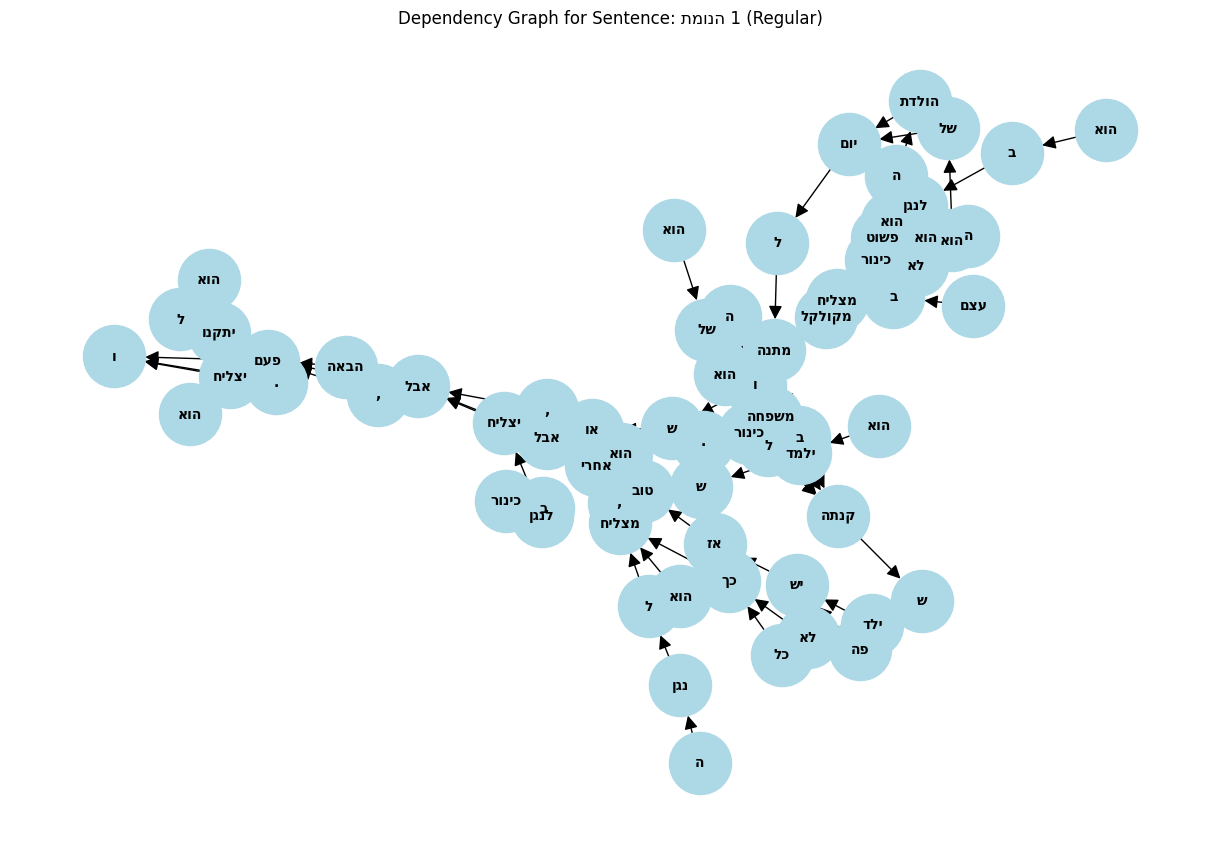

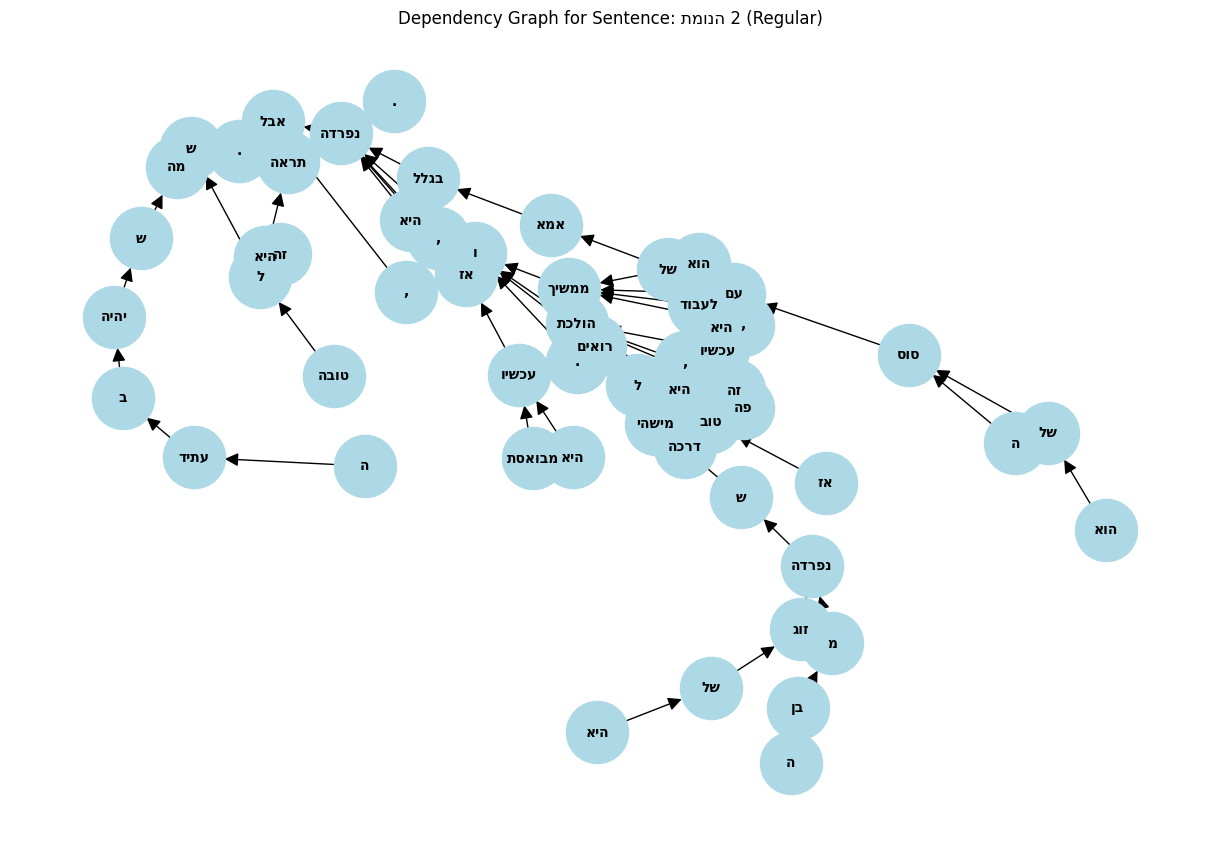

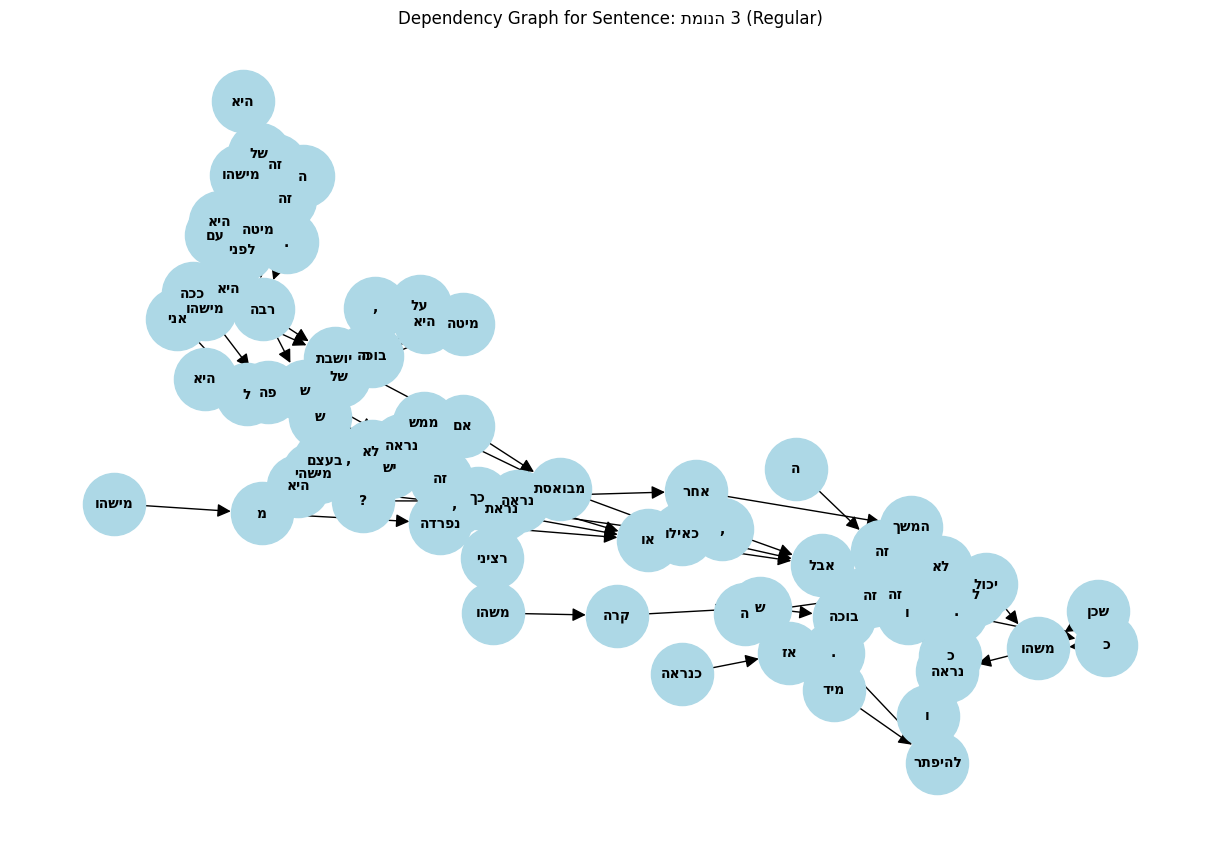

In [43]:
# Function to create and visualize dependency graph for each sentence
def visualize_dependency_graph(data):
    for sentence in data:
        yap_analysis = sentence["yap"]
        G = nx.DiGraph()  # Create a directed graph

        # Add nodes and edges in reverse order
        for word_info in reversed(yap_analysis):
            word_data = word_info['data']  # Adjusted to '0' assuming data is nested within index 0
            index = word_info['index']
            word = word_data['word']
            dependency_arc = word_data['dependency_arc']

            G.add_node(index, label=word[::-1])

            # Add edge based on dependency
            if dependency_arc != 0:  # 0 indicates root in some parsers
                G.add_edge(index, dependency_arc - 1)  # Reverse edge direction for reversed order

        # Draw graph
        pos = nx.spring_layout(G)  # Layout for visualization
        labels = nx.get_node_attributes(G, 'label')
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', arrowsize=20)
        plt.title(f"Dependency Graph for Sentence: {sentence['question']} ({'Schizophrenic' if sentence['label'] == 1 else 'Regular'})")
        plt.show()

# Call the function with parsed data
visualize_dependency_graph(data_js[:3])


## Features to Extract and Analyze
2 . Node Degree Distribution: Analyze the degree of each node (word) to understand the syntactic complexity.
3. Centrality Measures: Compute measures like betweenness centrality to understand the importance of each word in the sentence structure.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns

# Function to compute additional graph features
def compute_graph_features(G):
    features = {}

    # Compute average shortest path length for each strongly connected component
    if nx.is_strongly_connected(G):
        features['average_shortest_path_length'] = nx.average_shortest_path_length(G)
    else:
        # Get all strongly connected components
        scc = list(nx.strongly_connected_components(G))
        avg_path_lengths = []
        for component in scc:
            subgraph = G.subgraph(component)
            if len(subgraph) > 1:  # Skip single-node components
                try:
                    avg_path_lengths.append(nx.average_shortest_path_length(subgraph))
                except nx.NetworkXError:
                    avg_path_lengths.append(float('inf'))

        if avg_path_lengths:
            features['average_shortest_path_length'] = np.mean(avg_path_lengths)
        else:
            features['average_shortest_path_length'] = float('inf')

    # Other graph features
    features['degree_centrality'] = np.mean(list(nx.degree_centrality(G).values()))
    features['betweenness_centrality'] = np.mean(list(nx.betweenness_centrality(G).values()))
    features['clustering_coefficient'] = nx.average_clustering(G.to_undirected())

    return features

# Prepare DataFrame to store graph features
graph_features_list = []

# Compute features for each graph with tqdm for progress
print("Computing graph features for each sentence...\n")
for sentence in tqdm(data_js, desc="Processing Sentences", unit="sentence"):
    yap_analysis = sentence["yap"]
    G = nx.DiGraph()
    for word_info in yap_analysis:
        word_data = word_info['data']  # Adjust based on actual structure
        index = word_info['index']
        word = word_data['word']
        dependency_arc = word_data['dependency_arc']
        G.add_node(index, label=word)
        if dependency_arc != 0:
            G.add_edge(dependency_arc - 1, index)
    
    # Compute graph features
    graph_features = compute_graph_features(G)
    graph_features['label'] = sentence['label']
    graph_features_list.append(graph_features)

# Convert to DataFrame
features_df = pd.DataFrame(graph_features_list)

In [ ]:
features_df.head()

In [ ]:
features_df = features_df.drop(["average_shortest_path_length", "clustering_coefficient"], axis=1)

In [ ]:
def detect_outliers_tukey(df, column):
    """
    Detect outliers in a column using the Tukey method.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to detect outliers in.
    
    Returns:
        pd.Series: A boolean series indicating if a row is an outlier based on the column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

# Apply the function to detect outliers in each column you are interested in
outliers_df = pd.DataFrame()
for column in ['degree_centrality', 'betweenness_centrality']:  # replace with your columns of interest
    outliers_df[column] = detect_outliers_tukey(features_df, column)

# Exclude rows where any column has an outlier
df_without_outliers = features_df[~outliers_df.any(axis=1)]
print("DataFrame without outliers based on the Tukey method:")
df_without_outliers


In [ ]:
# Separate into two groups based on label
schizo_group = df_without_outliers[df_without_outliers['label'] == 1]
regular_group = df_without_outliers[df_without_outliers['label'] == 0]

In [ ]:
# Plotting Histograms
plt.figure(figsize=(14, 6))
for i, column in enumerate(['degree_centrality', 'betweenness_centrality']):
    plt.subplot(1, 3, i+1)
    sns.histplot(schizo_group[column], color='red', label='Schizophrenic', kde=True, stat="density", linewidth=0)
    sns.histplot(regular_group[column], color='blue', label='Regular', kde=True, stat="density", linewidth=0)
    plt.title(f'Histogram of {column}')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Plotting Box Plots
plt.figure(figsize=(14, 6))
for i, column in enumerate(['degree_centrality', 'betweenness_centrality']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='label', y=column, data=df_without_outliers)
    plt.title(f'Box plot of {column}')

plt.tight_layout()
plt.show()

### Degree centrality measures the number of direct connections a node has in a graph. In the context of a dependency graph, it represents how many direct dependencies each word (node) has.


In [ ]:
# T-Tests
from scipy.stats import ttest_ind

t_test_results = {}
for column in ['degree_centrality']:
    t_stat, p_value = ttest_ind(schizo_group[column], regular_group[column])
    t_test_results[column] = (t_stat, p_value)

# Display T-Test results
for feature, (t_stat, p_value) in t_test_results.items():
    print(f"\nT-Test for {feature}:")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
    
    # Null Hypothesis statement
    print(f"Null Hypothesis: There is no significant difference in the mean {feature} between schizophrenic and regular persons.")
    
    # Interpret results
    if p_value < 0.05:
        print("Result: Reject the null hypothesis. There is a statistically significant difference.")
    else:
        print("Result: Fail to reject the null hypothesis. There is no statistically significant difference.")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report

# Prepare data for logistic regression
features = ['degree_centrality']
X = df_without_outliers[features]
y = df_without_outliers['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Classification Report on Test Data
y_pred = log_reg.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
from scipy.stats import pointbiserialr

# Assuming 'label' is your binary target variable
y = df_without_outliers['label']

# Dictionary to store results
pointbiserial_results = {}

# Loop through each feature column
for column in df_without_outliers.columns:
    if column in {'degree_centrality'}:
        X = df_without_outliers[column]
        corr, p_value = pointbiserialr(y, X)
        pointbiserial_results[column] = (corr, p_value)

# Print results
for feature, (corr, p_value) in pointbiserial_results.items():
    print(f"Point-Biserial Correlation for {feature}: Corr={corr:.4f}, P-value={p_value:.4f}")


## 1. Average Dependency Length:

This feature represents the average length of dependencies in the tree. A higher average might suggest more complex sentences with more subordinate clauses or embedded structures.
Maximum Dependency Path Length:

This is the longest path between any two nodes in the dependency tree. It indicates how deeply nested the syntactic structures are. A longer path might suggest more complex sentence structures.
Dependency Distance:

The average distance between syntactically connected words. This feature gives an idea of how words are distributed in the sentence concerning their syntactic heads.

In [ ]:
def compute_dependency_length_features(data):
    """
    Compute dependency length and path features for each sentence.
    
    Parameters:
        data (list): List of sentences with their dependency parse information.
        
    Returns:
        list: List of dictionaries containing features for each sentence.
    """
    features_list = []

    for sentence in tqdm(data, desc="Computing Dependency Features"):
        yap_analysis = sentence["yap"]
        G = nx.DiGraph()  # Create a directed graph
        
        # Build the graph from the dependency analysis
        for word_info in yap_analysis:
            word_data = word_info['data']
            index = word_info['index']
            dependency_arc = word_data['dependency_arc']
            
            G.add_node(index)
            if dependency_arc != 0:  # Non-root word
                G.add_edge(dependency_arc - 1, index)  # Adjust for 0-based indexing

        # Compute Average Dependency Length
        dependency_lengths = [1 for _ in G.edges]  # Assuming each edge represents a length of 1
        avg_dependency_length = np.mean(dependency_lengths) if dependency_lengths else 0

        # Compute Maximum Dependency Path Length
        if nx.is_strongly_connected(G):
            max_dependency_path_length = nx.diameter(G)  # Only works if the graph is connected
        else:
            max_dependency_path_length = max(
                (nx.diameter(G.subgraph(c)) for c in nx.strongly_connected_components(G)), default=0
            )

        # Compute Dependency Distance
        dependency_distances = [abs(i - j) for i, j in G.edges]
        avg_dependency_distance = np.mean(dependency_distances) if dependency_distances else 0

        # Collect the features for the current sentence
        features = {
            "question": sentence["question"],
            "label": sentence["label"],
            "person": sentence["person"],
            "avg_dependency_length": avg_dependency_length,
            "max_dependency_path_length": max_dependency_path_length,
            "avg_dependency_distance": avg_dependency_distance
        }

        features_list.append(features)

    return features_list

In [ ]:
dependency_features = compute_dependency_length_features(data_js)

# Convert to DataFrame for further analysis
import pandas as pd
dependency_features_df = pd.DataFrame(dependency_features)

# Display the computed features
dependency_features_df.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Split data into schizophrenic and regular groups
schizo_group = dependency_features_df[dependency_features_df['label'] == 1]
regular_group = dependency_features_df[dependency_features_df['label'] == 0]

# Plot Histograms of Average Dependency Distances
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(schizo_group['avg_dependency_distance'], color='red', kde=True, label='Schizophrenic')
sns.histplot(regular_group['avg_dependency_distance'], color='blue', kde=True, label='Regular')
plt.title('Distribution of Average Dependency Distances')
plt.xlabel('Average Dependency Distance')
plt.ylabel('Frequency')
plt.legend()

# Plot Box Plots of Average Dependency Distances
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='avg_dependency_distance', data=dependency_features_df, palette=['blue', 'red'])
plt.title('Box Plot of Average Dependency Distances')
plt.xlabel('Group')
plt.ylabel('Average Dependency Distance')
plt.xticks([0, 1], ['Regular', 'Schizophrenic'])

plt.tight_layout()
plt.show()


## 2. Tree Structure Features
Subtree Depth and Width: Measures the maximum depth (longest path from root to leaf) and width (maximum number of nodes at any level) of the dependency tree. Schizophrenic sentences may show deeper or wider structures due to more complex sentence construction.
Branching Factor: Average number of children per node. A higher branching factor can indicate more complexity in the sentence structure.
Tree Shape and Balance: Features related to the balance of the tree (e.g., skewness, symmetry). Unbalanced trees might indicate irregular or less structured language use.

In [ ]:
import networkx as nx
import pandas as pd

def compute_tree_structure_features(yap_analysis):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges based on dependency arcs
    for word_info in yap_analysis:
        word_data = word_info['data']
        index = word_info['index']
        dependency_arc = word_data['dependency_arc']
        G.add_node(index)
        if dependency_arc != 0:
            G.add_edge(dependency_arc - 1, index)  # Adjust for 0-based indexing
    
    # Subtree depth (longest path from root to any leaf)
    try:
        depth = nx.dag_longest_path_length(G)
    except nx.NetworkXError:
        depth = float('inf')  # Handle disconnected graphs

    # Subtree width (maximum number of nodes at any level)
    path_lengths = nx.single_source_shortest_path_length(G, 0)
    width = max(list(path_lengths.values()).count(i) for i in set(path_lengths.values()))
    
    # Branching factor
    branching_factors = [len(list(G.neighbors(n))) for n in G.nodes()]
    avg_branching_factor = sum(branching_factors) / len(branching_factors) if branching_factors else 0
    
    # Tree shape and balance (dummy implementation, assuming "balance" is calculated differently)
    # In practice, you might compute a metric for tree symmetry or balance
    balance = 1 - abs(max(branching_factors) - min(branching_factors)) / len(branching_factors) if branching_factors else 0
    
    return {
        'subtree_depth': depth,
        'subtree_width': width,
        'avg_branching_factor': avg_branching_factor,
        'tree_balance': balance
}

# Apply the feature computation to each sentence
tree_features = []
for sentence in data_js:
    yap_analysis = sentence["yap"]
    features = compute_tree_structure_features(yap_analysis)
    features.update({'question': sentence['question'], 'label': sentence['label'], 'person': sentence['person']})
    tree_features.append(features)

# Convert to DataFrame for visualization
tree_features_df = pd.DataFrame(tree_features)

# Display the DataFrame

In [ ]:

# Visualize the differences as before
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into schizophrenic and regular groups
schizo_group = tree_features_df[tree_features_df['label'] == 1]
regular_group = tree_features_df[tree_features_df['label'] == 0]

# Features to visualize
features_to_plot = ['subtree_depth', 'subtree_width', 'avg_branching_factor', 'tree_balance']

# Plot histograms and box plots for each feature
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features_to_plot):
    # Histogram
    plt.subplot(4, 2, 2*i + 1)
    sns.histplot(schizo_group[feature], color='red', kde=True, label='Schizophrenic', bins=20)
    sns.histplot(regular_group[feature], color='blue', kde=True, label='Regular', bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

    # Box plot
    plt.subplot(4, 2, 2*i + 2)
    sns.boxplot(x='label', y=feature, data=tree_features_df, palette=['blue', 'red'])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel('Group')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Regular', 'Schizophrenic'])

plt.tight_layout()
plt.show()


## 3. Syntactic Role-Based Features
Frequency of Specific Dependency Relations: Count the occurrence of specific dependency relations (e.g., nsubj, dobj, iobj, advmod). Differences in the frequency of specific syntactic roles could indicate different language styles or patterns.
Ratio of Nominal to Verbal Dependencies: Compare the frequency of nominal (noun-related) dependencies to verbal (verb-related) ones. Schizophrenic speech might have a different balance of nouns to verbs.

In [ ]:
from collections import Counter
import pandas as pd

def compute_syntactic_role_features(yap_analysis):
    # Initialize counters for dependency relations
    dependency_counts = Counter()
    
    # Initialize counters for nominal and verbal dependencies
    nominal_count = 0
    verbal_count = 0
    
    # Define nominal and verbal dependency relations
    nominal_deps = {'nsubj', 'dobj', 'iobj', 'pobj', 'subj', 'obj', 'gobj'}
    verbal_deps = {'advmod', 'xcomp', 'ccomp', 'vmod', 'rcmod'}

    # Count the occurrences of each dependency relation
    for word_info in yap_analysis:
        word_data = word_info['data']
        dependency_part = word_data['dependency_part']
        
        # Count frequency of specific dependency relations
        dependency_counts[dependency_part] += 1
        
        # Check if the dependency is nominal or verbal
        if dependency_part in nominal_deps:
            nominal_count += 1
        elif dependency_part in verbal_deps:
            verbal_count += 1

    # Calculate ratio of nominal to verbal dependencies
    if verbal_count > 0:
        nominal_to_verbal_ratio = nominal_count / verbal_count
    else:
        nominal_to_verbal_ratio = float('inf')  # Handle division by zero
    
    return {
        'nominal_count': nominal_count,
        'verbal_count': verbal_count,
        'nominal_to_verbal_ratio': nominal_to_verbal_ratio,
        **{f'freq_{dep}': count for dep, count in dependency_counts.items()}
    }

# Apply the feature computation to each sentence
syntactic_features = []
for sentence in data_js:
    yap_analysis = sentence["yap"]
    features = compute_syntactic_role_features(yap_analysis)
    features.update({'question': sentence['question'], 'label': sentence['label'], 'person': sentence['person']})
    syntactic_features.append(features)

# Convert to DataFrame for visualization
syntactic_features_df = pd.DataFrame(syntactic_features)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Box Plot for Nominal to Verbal Ratio
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='nominal_to_verbal_ratio', data=syntactic_features_df)
plt.title('Box plot of Nominal to Verbal Ratio')
plt.xlabel('Label (0: Regular, 1: Schizophrenic)')
plt.ylabel('Nominal to Verbal Ratio')
plt.show()


## 4. Syntactic Complexity Measures
Parse Tree Complexity: Directly measure the complexity of the dependency parse tree (e.g., tree depth, number of nodes). More complex trees might correlate with more complex, less straightforward language.
Coordination and Subordination Features: Counts and ratios of coordinated (e.g., conjunctions like "and", "or") vs. subordinated clauses (e.g., "because", "if"). Schizophrenic speech might use more complex subordinated clauses.

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

def compute_syntactic_complexity_features(yap_analysis):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges based on dependency arcs
    for word_info in yap_analysis:
        word_data = word_info['data']
        index = word_info['index']
        dependency_arc = word_data['dependency_arc']
        G.add_node(index)
        if dependency_arc != 0:
            G.add_edge(dependency_arc - 1, index)  # Adjust for 0-based indexing
    
    # Parse Tree Complexity
    try:
        tree_depth = nx.dag_longest_path_length(G)  # Tree Depth
    except nx.NetworkXError:
        tree_depth = float('inf')  # Handle disconnected graphs
    
    num_nodes = G.number_of_nodes()  # Number of Nodes

    # Coordination and Subordination Features using POS tags
    coordination_count = 0
    subordination_count = 0

    # POS tags for coordination and subordination
    coordination_pos_tags = {'CC'}  # Coordinating conjunction
    subordination_pos_tags = {'IN', 'REL'}  # Subordinating conjunction or relative clause marker

    for word_info in yap_analysis:
        pos = word_info['data']['pos']
        if pos in coordination_pos_tags:
            coordination_count += 1
        elif pos in subordination_pos_tags:
            subordination_count += 1

    if subordination_count > 0:
        coord_to_subord_ratio = coordination_count / subordination_count
    else:
        coord_to_subord_ratio = float('inf')  # Avoid division by zero

    return {
        'tree_depth': tree_depth,
        'num_nodes': num_nodes,
        'coordination_count': coordination_count,
        'subordination_count': subordination_count,
        'coord_to_subord_ratio': coord_to_subord_ratio
    }

# Apply the feature computation to each sentence
complexity_features = []
for sentence in data_js:
    yap_analysis = sentence["yap"]
    features = compute_syntactic_complexity_features(yap_analysis)
    features.update({'question': sentence['question'], 'label': sentence['label'], 'person': sentence['person']})
    complexity_features.append(features)

# Convert to DataFrame for visualization
complexity_features_df = pd.DataFrame(complexity_features)

In [ ]:

# Visualize the Tree Depth and Coordination to Subordination Ratio
plt.figure(figsize=(14, 6))

# Tree Depth Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='tree_depth', data=complexity_features_df)
plt.title('Box plot of Tree Depth')
plt.xlabel('Label (0: Regular, 1: Schizophrenic)')
plt.ylabel('Tree Depth')

# Coordination to Subordination Ratio Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='coord_to_subord_ratio', data=complexity_features_df)
plt.title('Box plot of Coordination to Subordination Ratio')
plt.xlabel('Label (0: Regular, 1: Schizophrenic)')
plt.ylabel('Coordination to Subordination Ratio')

plt.tight_layout()
plt.show()


## 5. Morpho-Syntactic Features
POS-Tag Sequences: Sequences and patterns of part-of-speech tags can provide insight into language style and complexity. Schizophrenic speech might exhibit different POS patterns.
Morphological Variations: Analysis of morphological features like tense, gender, number, and person. Different usage patterns may emerge between groups.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def compute_pos_tag_sequences(yap_analysis):
    """
    Compute POS tag sequences for each sentence.
    
    Parameters:
        yap_analysis (list): List containing word analysis from YAP output.
    
    Returns:
        dict: Dictionary with counts of POS tag sequences.
    """
    pos_tags = [word_info['data']['pos'] for word_info in yap_analysis]
    pos_sequence = ' '.join(pos_tags)
    
    return {'pos_sequence': pos_sequence, 'pos_count': Counter(pos_tags)}

def compute_morphological_variations(yap_analysis):
    """
    Compute morphological features like tense, gender, number, and person.
    
    Parameters:
        yap_analysis (list): List containing word analysis from YAP output.
    
    Returns:
        dict: Dictionary with counts of morphological variations.
    """
    tense_count = Counter()
    gender_count = Counter()
    number_count = Counter()
    person_count = Counter()

    for word_info in yap_analysis:
        word_data = word_info['data']
        # Count morphological variations
        tense_count[word_data['tense']] += 1
        gender_count[word_data['gen']] += 1
        number_count[word_data['num_s_p']] += 1
        person_count[word_data['per']] += 1
    
    return {
        'tense_count': tense_count,
        'gender_count': gender_count,
        'number_count': number_count,
        'person_count': person_count
    }

# Apply the feature computation to each sentence
morpho_syntactic_features = []
for sentence in data_js:
    yap_analysis = sentence["yap"]
    
    # Compute POS tag sequences
    pos_features = compute_pos_tag_sequences(yap_analysis)
    
    # Compute morphological variations
    morpho_features = compute_morphological_variations(yap_analysis)
    
    # Combine all features
    all_features = {**pos_features, **morpho_features}
    all_features.update({'question': sentence['question'], 'label': sentence['label'], 'person': sentence['person']})
    morpho_syntactic_features.append(all_features)

# Convert to DataFrame for analysis
morpho_syntactic_df = pd.DataFrame(morpho_syntactic_features)


In [ ]:
morpho_syntactic_df.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify all columns with 'count' in their name
count_columns = [col for col in morpho_syntactic_df.columns if 'count' in col]

# Loop over each 'count' column and create a plot
for count_col in count_columns:
    # Create a new DataFrame for plotting
    count_data = []
    for index, row in morpho_syntactic_df.iterrows():
        if count_col in row:
            for item, count in row[count_col].items():
                if item != -1:  # Exclude undefined or irrelevant items
                    count_data.append({count_col: item, 'count': count, 'label': row['label']})
    
    # Convert the list to a DataFrame for plotting
    count_df = pd.DataFrame(count_data)
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.barplot(x=count_col, y='count', hue='label', data=count_df)
    plt.title(f'Distribution of {count_col} Usage')
    plt.xlabel(count_col)
    plt.ylabel('Count')
    plt.legend(title='Label (0: Regular, 1: Schizophrenic)')
    plt.show()


## 6. Sentence-Level Complexity and Readability Features
Syntactic Surprisal: Measures the unexpectedness of a syntactic structure. Higher surprisal might be observed in more disorganized or unpredictable language.
Readability Scores: Flesch-Kincaid, Gunning Fog Index, etc. These can provide a general sense of complexity or readability that might differ between groups.

In [ ]:
!pip install textstat

In [ ]:
from collections import Counter
import itertools

# Extract POS sequences from the dataset
def extract_pos_sequences(data_js):
    pos_sequences = []
    for sentence in data_js:
        yap_analysis = sentence["yap"]
        pos_sequence = [word_info['data']['pos'] for word_info in yap_analysis]
        pos_sequences.extend(list(zip(pos_sequence[:-1], pos_sequence[1:])))  # Get consecutive pairs
    return pos_sequences

# Count the frequency of each POS sequence
def count_pos_sequences(pos_sequences):
    return Counter(pos_sequences)

# Identify rare sequences based on a frequency threshold
def identify_rare_sequences(pos_sequence_counts, threshold=5):
    rare_sequences = [seq for seq, count in pos_sequence_counts.items() if count <= threshold]
    return rare_sequences

# Extract POS sequences from your dataset
pos_sequences = extract_pos_sequences(data_js)

# Count frequency of each POS sequence
pos_sequence_counts = count_pos_sequences(pos_sequences)

# Identify rare sequences
rare_sequences = identify_rare_sequences(pos_sequence_counts, threshold=5)

print(f"Identified TOP 10 Rare Sequences: {rare_sequences[:10]}")

# Update your surprisal calculation function to use the identified rare sequences
def calculate_syntactic_surprisal(yap_analysis, rare_sequences):
    surprisal_score = 0
    pos_sequence = [word_info['data']['pos'] for word_info in yap_analysis]
    
    # Count rare sequences
    for i in range(len(pos_sequence) - 1):
        if (pos_sequence[i], pos_sequence[i + 1]) in rare_sequences:
            surprisal_score += 1
    
    return surprisal_score / len(pos_sequence) if len(pos_sequence) > 0 else 0

# Apply the feature computation to each sentence
readability_features = []
for sentence in data_js:
    yap_analysis = sentence["yap"]
    
    # Calculate surprisal score
    surprisal_score = calculate_syntactic_surprisal(yap_analysis, rare_sequences)
    
    # Convert back to plain text for readability
    plain_text_sentence = ' '.join([word_info['data']['word'] for word_info in yap_analysis])
    
    # Calculate readability scores
    readability_scores = calculate_readability_scores(plain_text_sentence)
    
    # Combine features
    features = {'question': sentence['question'], 'person': sentence['person'], 'label': sentence['label'], 'syntactic_surprisal': surprisal_score}
    features.update(readability_scores)
    readability_features.append(features)

# Convert to DataFrame for visualization
readability_features_df = pd.DataFrame(readability_features)

# Display the DataFrame
readability_features_df.head()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot of surprisal scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='syntactic_surprisal', data=readability_features_df)
plt.title('Box plot of Syntactic Surprisal Scores')
plt.xlabel('Label (0: Regular, 1: Schizophrenic)')
plt.ylabel('Syntactic Surprisal Score')
plt.show()

# Box plot of Flesch-Kincaid Grade Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='flesch_kincaid_grade', data=readability_features_df)
plt.title('Box plot of Flesch-Kincaid Grade Level')
plt.xlabel('Label (0: Regular, 1: Schizophrenic)')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.show()

# Scatter plot for Gunning Fog
plt.figure(figsize=(10, 6))
sns.scatterplot(x='flesch_reading_ease', y='gunning_fog', hue='label', data=readability_features_df)
plt.title('Scatter plot of Readability Scores')
plt.xlabel('Flesch Reading Ease')
plt.ylabel('Gunning Fog')
plt.show()


In [ ]:
# Merge all feature DataFrames on the 'question' column (common identifier)
feature_matrix = pd.merge(dependency_features_df, tree_features_df, on=['question', 'person', 'label'], how='outer')
feature_matrix = pd.merge(feature_matrix, syntactic_features_df, on=['question', 'person', 'label'], how='outer')
feature_matrix = pd.merge(feature_matrix, readability_features_df, on=['question', 'person', 'label'], how='outer')

# Display the consolidated feature matrix
print("Consolidated Feature Matrix:")
feature_matrix.head()


In [ ]:
len(feature_matrix)

In [ ]:
last_feature_matrix = feature_matrix.dropna(axis=1)

In [ ]:
last_feature_matrix.isna().sum().sum()

In [ ]:
feature_matrix = feature_matrix.drop(columns=["person", "question"])

# Replace inf values with NaN
feature_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the mean of their respective columns
feature_matrix.fillna(feature_matrix.mean(), inplace=True)

In [ ]:
# Check which columns are not numeric
non_numeric_columns = feature_matrix.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

# Convert columns to numeric if possible, coercing errors to NaN
feature_matrix[non_numeric_columns] = feature_matrix[non_numeric_columns].apply(pd.to_numeric, errors='coerce')

# Now replace inf with NaN
feature_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN with column mean
feature_matrix.fillna(feature_matrix.mean(), inplace=True)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

# Ensure all data is numeric
feature_matrix = feature_matrix.apply(pd.to_numeric, errors='coerce')

# Replace inf and -inf with NaN
feature_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN with column mean
feature_matrix.fillna(feature_matrix.mean(), inplace=True)

# Verifying that all columns are now numeric
print(feature_matrix.dtypes)

# Perform the point-biserial correlation
target_label = feature_matrix['label']  # Replace with your target label column
correlation_results = {}

# Remove the 'label' column for correlation calculations
features = feature_matrix.drop(columns=['label'])

# Calculate correlations
for column in features.columns:
    corr, p_value = pointbiserialr(target_label, features[column])
    correlation_results[column] = (corr, p_value)
    print(f"Correlation between 'label' and '{column}': {corr:.4f}, p-value: {p_value:.4f}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Filtered features based on correlation analysis
important_features = [
    'avg_dependency_distance', 'subtree_depth', 'avg_branching_factor',
    'tree_balance', 'nominal_count', 'verbal_count', 'nominal_to_verbal_ratio',
    'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog'
]

# Prepare DataFrame with only important features
filtered_df = feature_matrix[important_features + ['label']]

# Handle NaN values if any
filtered_df = filtered_df.fillna(filtered_df.mean())

# Separate features and target
X = filtered_df.drop('label', axis=1)
y = filtered_df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Conduct Feature Importance Analysis using Random Forest

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Compute feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importances:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Step 3: Permutation Importance for Validation

perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42)
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})

# Sort by importance
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Display permutation importance
print("Permutation Importances:")
print(perm_importance_df)

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='lightcoral')
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Define a threshold for feature selection (you can adjust this value)
threshold = 0.05

# Feature selection based on importance
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']
selected_features = selected_features[selected_features.isin(perm_importance_df[perm_importance_df['Importance'] > threshold]['Feature'])]

# Prepare data with selected features
X_selected = filtered_df[selected_features]
y_selected = filtered_df['label']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Filtered features based on correlation analysis
important_features = [
    'avg_dependency_distance', 'subtree_depth', 'avg_branching_factor',
    'tree_balance', 'nominal_count', 'verbal_count', 'nominal_to_verbal_ratio',
    'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog'
]

# Prepare DataFrame with only important features
filtered_df = feature_matrix[important_features + ['label']]

# Handle NaN values if any
filtered_df = filtered_df.fillna(filtered_df.mean())

# Separate features and target
X = filtered_df.drop('label', axis=1)
y = filtered_df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
filtered_df

In [146]:
# 1. XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Classifier Report:")
# Continue with XGBoost Classifier evaluation
print(classification_report(y_test, xgb_pred))
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")


XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       221
           1       0.69      0.41      0.51        66

    accuracy                           0.82       287
   macro avg       0.77      0.68      0.70       287
weighted avg       0.81      0.82      0.80       287

XGBoost Accuracy: 0.8223


In [147]:
# 2. K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("K-Nearest Neighbors Classifier Report:")
print(classification_report(y_test, knn_pred))
print(f"KNN Accuracy: {accuracy_score(y_test, knn_pred):.4f}")


K-Nearest Neighbors Classifier Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       221
           1       0.66      0.44      0.53        66

    accuracy                           0.82       287
   macro avg       0.75      0.69      0.71       287
weighted avg       0.80      0.82      0.80       287

KNN Accuracy: 0.8188


In [148]:

# 3. Support Vector Machine Classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("Support Vector Machine Classifier Report:")
print(classification_report(y_test, svm_pred))
print(f"SVM Accuracy: {accuracy_score(y_test, svm_pred):.4f}")


Support Vector Machine Classifier Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       221
           1       0.81      0.33      0.47        66

    accuracy                           0.83       287
   macro avg       0.82      0.66      0.69       287
weighted avg       0.83      0.83      0.80       287

SVM Accuracy: 0.8293
